In [272]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/ph/wcdfy27570nc5m2_jjy6g9q00000gn/T/ipykernel_6147/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


## Contents

## Imports, etc.

In [464]:
from plotnine import *
import numpy as np
import datetime
from scipy.stats import norm

In [275]:
import os
import pandas as pd
pd.set_option('display.max_rows',500)

import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

## Introduction

In the farms built after Farm 1, trays are grouped two to a bay. Because the bay represents a single irrigation zone, an alteration (such as removing a tray) means interrupting the irrigation of both trays ("bay partners").

This informs some conservative behaviors, chiefly that when the crop occupying one bay fails we tend to let its partner continue to harvest if it appears to be healthy. Leaving the dead crop costs spacetime, however.

Under certain circumstances, it may be that allowing the healthy partner to continue to harvest is not worth the investment. When this determination is made, the healthy crop will be terminated, both will be removed from the farm, and the space will be made available to future crops.

## Intuition

We define the following terms:
 
 * $r$ : the number of tray days prescribed by a recipe
 * $s$ : a unit of spacetime equal to the space used by one tray for one day
 * $c$ : the proportion of recipe-prescribed tray days which have elapsed when a crop is culled
 * $m$ : the expected salable mass of a crop
 * $y$ : yield, defined as $\frac{m}{s\times r}$
 
Under normal circumstances we expect a bay to produce $2m$ lbs of mass, and consume $2sr$ units of spacetime, resulting in the expected yield of $$y = \frac{m + m}{2\times s\times r} = \frac{m}{s\times r}$$

To evaluate if and when these full bay terminations should occur, we consider the following scenarios:

#### A failed partner has no impact on the living partner
If we allow the partner of a failed crop to be harvested as scheduled, and if

$$\mathbb{E} (m|partnerFailure) = \mathbb{E} (m)$$

that is, a failed partner has no effect on the surviving partner, then our bay yield becomes $$\frac{m+0}{2\times s\times r} = \frac{1}{2}\frac{m}{s\times r}$$
as the space of the failed crop yields zero.

#### A failed partner has a negative impact on the living partner
If the failure of one crop in the bay is correlated with a negative impact on its partner crop, 

$$\mathbb{E} (m|partnerFailure) < \mathbb{E} (m)$$

then the expected yield of harvesting the remaining crop is naturally

$$y' = \frac{m'}{2\times s\times r}$$ for some $m' < m$.


#### Spacetime recovery
Suppose now a crop has failed on day $\lfloor c\cdot r \rfloor$, or $c\%$ into its expected grow period. (Here we ignore that in the seedling stage daily space consumption is lower.) If we terminate its partner and free the bay, then we effectively zero out the bay yield. 

One perspective on reusing the spacetime is that we plant a new pair of crops in the bay. These new crops have their own total spacetime needs of $2\times s \times r$, and we would amortize the prior failed crop spacetime into the yield calculation producing a yield of 

$$\begin{aligned} y^* &= \frac{0+0+m+m}{c\cdot(2\times s\times r)+(2\times s\times r)}\\
&=\frac{2m}{(2\times s\times r)(1+c)}\\
&=\frac{1}{1+c}\cdot\frac{m}{s\times r}
\end{aligned}$$

Another perspective is to not worry about the whole life of the replacement crop, but rather only the value generated in the $\lfloor (1-c)\cdot r\rfloor$ days freed by the early termination. In this case we can just hold the spacetime used constant, and estimate the new planting's fractional return 

$$\begin{aligned}y^{**}&=\frac{0+0+(1-c)\times 2\times m}{2\times s\times r}\\ &= (1-c)\cdot\frac{m}{s\times r}\end{aligned}$$

<p style="color:red">Note: in a full farm these are an optimstic estimates, as a replacement crop may later be culled for space and produce 0 yield.</p>

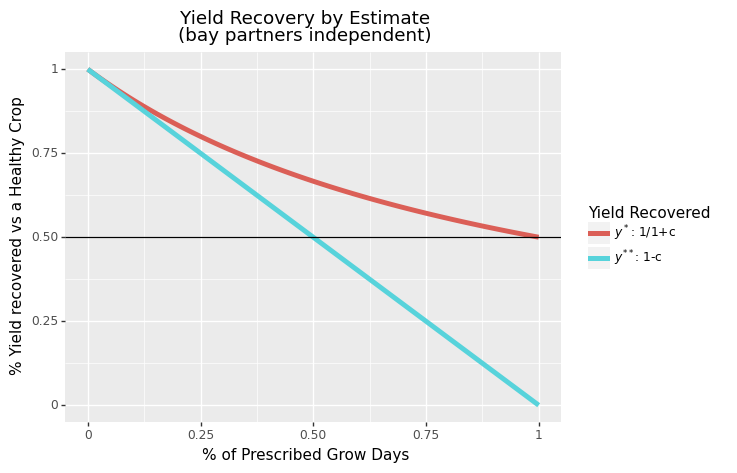

<ggplot: (350034878)>

In [40]:
(
    pd.DataFrame({
        'x':np.tile(np.linspace(0,1,100),2),
        'y':np.concatenate(((1-np.linspace(0,1,100)),(1/(1+np.linspace(0,1,100))))),
        'Yield Recovered':(['$y^{**}$: 1-c']*100) + (['$y^*$: 1/1+c']*100)
    })
    .pipe(lambda d: ggplot(d, aes(x='x',y='y',color='Yield Recovered')) 
          + geom_line(size=2)
          + geom_hline(yintercept=0.5)
          + labs(y="% Yield recovered vs a Healthy Crop",
                 x="% of Prescribed Grow Days")
          + ggtitle("Yield Recovery by Estimate\n(bay partners independent)"))
)

The question of when action should be taken depends upon how we do our accounting: If $y^*$ is our approach then we should always terminate a whole bay whereas if $y^{**}$ then we should only terminate the bay if a crop has not yet passed the halfway point of its lifetime.

The calculation becomes more generous in favor of $y^{**}$ if there's a negative effect from a failed bay partner on a surviving partner: in this case, we should terminate the bay whenever

$$1-c \ge \frac{1}{2}\frac{\mathbb{E} (m|partnerFailure)}{\mathbb{E} (m)}$$

Concretely, if a crop fails on day 7 of a 10 day recipe, we could get 30% of two healthy crops by replanting immediately. If the remaining crop can be $\ge$ 60% of a normal mass then we should keep it, otherwise the replanting will produce more mass:

$$\begin{aligned}
1-0.7 &\ge \frac{1}{2}\frac{0.6\cdot m}{m}\\
0.3 &\ge \frac{0.6}{2}\\
0.3 &\ge 0.3
\end{aligned}$$

If the crop were to generate an estimated 75% of a healthy mass then we shouldn't terminate:

$$\begin{aligned}
1-0.7 &\ge \frac{1}{2}\frac{0.75\cdot m}{m}\\
0.3 &\ge \frac{0.75}{2}\\
0.3 &\ngtr 0.375
\end{aligned}$$

In order to proceed the following questions must be answered:
 * **Does crop failure adversely impact the mass of surviving bay partners?**
 * **What is the frequency of partial bay failure, and how much additional mass can be generated by terminating and replacing the bay?**

## Study

### Failure Rate Incidence
Will a failed bay partner increase the risk of failure of the other crop? 

We will estimate this by, for each recipe, computing 

$$P(failure_{daysRemaining \geq X})$$ 

for each value of X < # grow days in recipe. The question then will be is this independent of bay partner failure, that is

$$P(failure_{daysRemaining \geq X}) \neq P(failure_{daysRemaining \geq X}|bayPartnerFailed_{before X})$$ 


How often do both crops fail but on different days?

### Bay Pairs Query

This query forms the basis for most of the following analysis. This query:
 * finds the minimum time per crop (if any) where the probability of failure was predicted at >= 80%
 * select all the crops in farm 2, building a struct with their salient information
 * group together the structs by bay, component, seeding date and scheduled completion date
 * select out items from the grouped structs giving us clean data for bay partners A and B

In [342]:
BAY_PAIRS_SUBQUERY = """
    with min_failure_threshold_predict as (
      select crop_id, min(hour_starting_at)::date as failure_predict_date,
        case when failure_probability >= 0.8 then 1 else 0 end as failure_threshold
      from predict.m_crop_mass_preds
      group by crop_id, failure_threshold
      having failure_threshold = 1
    ),
    crops as (
        select p.bay_position,
          object_construct(
            'crop_id',c.crop_id,
            'outcome',c.outcome,
            'recipe_id', c.recipe_id,
            'requested_termination_at',c.requested_termination_at,
            'salable_mass_lbs',c.salable_mass_lbs,
            'termination_grow_day', case when c.requested_termination_at is not null then datediff('day',c.seeded_on, c.requested_termination_at) else -1 end,
            'first_failure_pred_day', case when failure_predict_date is not null then datediff('day',c.seeded_on, r.failure_predict_date) else -1 end
          ) as crop_details,
          seeded_on,
          outcome,
          requested_termination_at,
          component_id,
          completed_on_scheduled,
          p.bay_id
        from warehouse.dm_crops c
        join warehouse.dm_positions p on c.grow_1_position_id = p.position_id
        left join min_failure_threshold_predict r using (crop_id)

        where c.farm_id = 2
          and c.outcome <> 'in-flight'
          and crop_id not in (68312,68310,68311) -- for some reason these crops purport to be three to a bay?
          and (failure_predict_date <= completed_on_scheduled or failure_predict_date is null)              
    ),
    by_bay as (
        select object_agg(bay_position, crop_details) as bay_crops,
          bay_id, 
          component_id, 
          seeded_on, 
          completed_on_scheduled
        from crops
        -- this will remove mixed recipe bays, mixed date bays
        group by bay_id, 
          component_id, 
          seeded_on, 
          completed_on_scheduled
    ),
    bay_pairs as (
      select as_integer(bay_crops:a:crop_id) as crop_a,
        as_char(bay_crops:a:outcome) as outcome_a,
        as_double(bay_crops:a:salable_mass_lbs) as salable_mass_lbs_a,
        as_integer(bay_crops:a:first_failure_pred_day) as first_failure_pred_day_a,
        as_integer(bay_crops:a:recipe_id) as recipe_id_a,
        as_integer(bay_crops:a:termination_grow_day) as termination_grow_day_a,

        as_integer(bay_crops:b:crop_id) as crop_b,
        as_char(bay_crops:b:outcome) as outcome_b,
        as_double(bay_crops:b:salable_mass_lbs) as salable_mass_lbs_b,
        as_integer(bay_crops:b:first_failure_pred_day) as first_failure_pred_day_b,
        as_integer(bay_crops:b:recipe_id) as recipe_id_b,
        as_integer(bay_crops:b:termination_grow_day) as termination_grow_day_b,

        component_id, 
        seeded_on, 
        completed_on_scheduled, 
        datediff('day',seeded_on, completed_on_scheduled) as recipe_days
      from by_bay
      where crop_a is not null
        and crop_b is not null
    )
"""

In [343]:
qry = f"""
  {BAY_PAIRS_SUBQUERY}
  select *
  from bay_pairs
  where crop_a = 177781
"""
pd.read_sql(qry,conn)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,CROP_A,OUTCOME_A,SALABLE_MASS_LBS_A,FIRST_FAILURE_PRED_DAY_A,RECIPE_ID_A,TERMINATION_GROW_DAY_A,CROP_B,OUTCOME_B,SALABLE_MASS_LBS_B,FIRST_FAILURE_PRED_DAY_B,RECIPE_ID_B,TERMINATION_GROW_DAY_B,COMPONENT_ID,SEEDED_ON,COMPLETED_ON_SCHEDULED,RECIPE_DAYS
0,177781,complete,10.769,-1,516,-1,177783,complete,21.398,16,516,-1,14,2022-01-22,2022-02-13,22


### How many unmatched failures are there?

To determine whether or not one bay failing has an impact on a second bay's chance of failure, we need to find instances where both bays fail, not at the same time, or an "unmatched failure".

In [312]:
qry = f"""
{BAY_PAIRS_SUBQUERY}
select component_id,
  sum(case when termination_grow_day_a = -1 and termination_grow_day_b = -1 then 1 else 0 end) as success,
  sum(case when termination_grow_day_a > 0 and termination_grow_day_b > 0 and termination_grow_day_a = termination_grow_day_b then 1 else 0 end) as matched_failure,
  sum(case when termination_grow_day_a > 0 and termination_grow_day_b > 0 and termination_grow_day_a <> termination_grow_day_b then 1 else 0 end) as unmatched_failure,
  sum(case when ((termination_grow_day_a = -1 and termination_grow_day_b <> -1) or (termination_grow_day_a <> -1 and termination_grow_day_b = -1)) then 1 else 0 end) as single_failure,
  count(1) as n

from bay_pairs 
group by component_id
order by n desc
"""
print(pd.read_sql(qry,conn).head(n=20).to_markdown())

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


|    |   COMPONENT_ID |   SUCCESS |   MATCHED_FAILURE |   UNMATCHED_FAILURE |   SINGLE_FAILURE |     N |
|---:|---------------:|----------:|------------------:|--------------------:|-----------------:|------:|
|  0 |             14 |     11659 |               802 |                   7 |              269 | 12737 |
|  1 |             12 |     11166 |               448 |                  13 |              268 | 11895 |
|  2 |              4 |      7451 |               302 |                   2 |              212 |  7967 |
|  3 |             15 |      5347 |               311 |                   5 |              253 |  5916 |
|  4 |             10 |      4988 |               156 |                   1 |              179 |  5324 |
|  5 |              6 |      4042 |               497 |                  15 |              191 |  4745 |
|  6 |             11 |      2595 |               117 |                   2 |               41 |  2755 |
|  7 |             17 |      2353 |               175 |

...this is not a lot. What if rather than date of requested terminations, let's look at "first day with predicted failure $\geq$ 80%".

In [344]:
qry = f"""
  {BAY_PAIRS_SUBQUERY}
    select component_id,
      sum(case when first_failure_pred_day_a = -1 and first_failure_pred_day_b = -1 then 1 else 0 end) as success,
      sum(case when first_failure_pred_day_a > 0 
          and first_failure_pred_day_b > 0 
          and first_failure_pred_day_a = first_failure_pred_day_b 
          then 1 else 0 end) as matched_failure,
      sum(case when first_failure_pred_day_a > 0 
          and first_failure_pred_day_b > 0 
          and first_failure_pred_day_a <> first_failure_pred_day_b 
          then 1 else 0 end) as unmatched_failure,
      sum(case when ((first_failure_pred_day_a = -1 and first_failure_pred_day_b <> -1) 
          or (first_failure_pred_day_a <> -1 and first_failure_pred_day_b = -1)) 
          then 1 else 0 end) as single_failure,
      count(1) as n,
      
      success + matched_failure + unmatched_failure + single_failure as check_total

    from bay_pairs 
    group by component_id
    order by n desc
"""
print(pd.read_sql(qry,conn).to_markdown())

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


|    |   COMPONENT_ID |   SUCCESS |   MATCHED_FAILURE |   UNMATCHED_FAILURE |   SINGLE_FAILURE |     N |   CHECK_TOTAL |
|---:|---------------:|----------:|------------------:|--------------------:|-----------------:|------:|--------------:|
|  0 |             14 |     11430 |               477 |                 240 |              590 | 12737 |         12737 |
|  1 |             12 |     10842 |               273 |                 224 |              556 | 11895 |         11895 |
|  2 |              4 |      7325 |               315 |                  65 |              262 |  7967 |          7967 |
|  3 |             15 |      5112 |               465 |                 100 |              242 |  5919 |          5919 |
|  4 |             10 |      4882 |               161 |                  81 |              202 |  5326 |          5326 |
|  5 |              6 |      4236 |               145 |                 129 |              235 |  4745 |          4745 |
|  6 |             11 |      265

These unmatched failures may be enough, let's investigate:

### P(A) = P(A|B)?

Begin by computing, per recipe, $P(failure_{daysRemaining > X})$, specifically for crops in the A position:

In [345]:
qry = f"""
{BAY_PAIRS_SUBQUERY},
    counts_a as (
        select count(1) as n_a,
          component_id,
          first_failure_pred_day_b as first_failure_pred_day
        from bay_pairs 
        group by component_id,
          first_failure_pred_day_b
        order by first_failure_pred_day
    ),
    stats_a as (
        select n_a,
          component_id,
          sum(n_a) over(partition by component_id) as total_n_a,
          first_failure_pred_day,
          sum(n_a) over(partition by component_id order by first_failure_pred_day desc rows between unbounded preceding and current row) as failure_cum_a,
          failure_cum_a / total_n_a as failure_given_grow_day_a
        from counts_a
    )
    select *
    from stats_a
    order by component_id, first_failure_pred_day desc
"""
df_individual = pd.read_sql(qry,conn)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [346]:
print(df_individual.head(n=20).to_markdown())

|    |   N_A |   COMPONENT_ID |   TOTAL_N_A |   FIRST_FAILURE_PRED_DAY |   FAILURE_CUM_A |   FAILURE_GIVEN_GROW_DAY_A |
|---:|------:|---------------:|------------:|-------------------------:|----------------:|---------------------------:|
|  0 |    54 |              1 |          54 |                       -1 |              54 |                   1        |
|  1 |    28 |              2 |          28 |                       -1 |              28 |                   1        |
|  2 |     7 |              3 |         234 |                        5 |               7 |                   0.029915 |
|  3 |     9 |              3 |         234 |                        4 |              16 |                   0.068376 |
|  4 |   218 |              3 |         234 |                       -1 |             234 |                   1        |
|  5 |     1 |              4 |        7967 |                       19 |               1 |                   0.000126 |
|  6 |     2 |              4 |        7

And then $P(failure_{daysRemaining \geq X}|bayPartnerFailed_{before X})$, *i.e.* $P(A|B)$:

In [347]:
qry = f"""
{BAY_PAIRS_SUBQUERY},
    day_counts as (
      select count(1) as n,
        component_id,
        first_failure_pred_day_a
      from bay_pairs
      where first_failure_pred_day_b <> -1                           -- b has failed
        and (first_failure_pred_day_b < first_failure_pred_day_a     -- b failed before a failed
          or first_failure_pred_day_a = -1)                          --  or a hasn't failed at all
      group by component_id,
        first_failure_pred_day_a
    ),
    given_b_failed as (                                              -- this block gives us a cumulative failure rate, 
        select component_id,                                         -- such that our probability is "failed on or after
          sum(n) over(partition by component_id) as total_n_a,       -- grow day X"
          first_failure_pred_day_a as first_failure_pred_day,
          sum(n) over(partition by component_id order by first_failure_pred_day_a desc rows between unbounded preceding and current row) as failure_cum_a,
          failure_cum_a / total_n_a as a_given_b_failed
        from day_counts
    )
    select * 
    from given_b_failed
"""
df_conditional = pd.read_sql(qry,conn)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [348]:
print(df_conditional.head(n=20).to_markdown())

|    |   COMPONENT_ID |   TOTAL_N_A |   FIRST_FAILURE_PRED_DAY |   FAILURE_CUM_A |   A_GIVEN_B_FAILED |
|---:|---------------:|------------:|-------------------------:|----------------:|-------------------:|
|  0 |             14 |         364 |                       27 |               1 |           0.002747 |
|  1 |             14 |         364 |                       26 |               2 |           0.005495 |
|  2 |             14 |         364 |                       25 |               3 |           0.008242 |
|  3 |             14 |         364 |                       23 |               7 |           0.019231 |
|  4 |             14 |         364 |                       22 |              10 |           0.027473 |
|  5 |             14 |         364 |                       21 |              14 |           0.038462 |
|  6 |             14 |         364 |                       20 |              17 |           0.046703 |
|  7 |             14 |         364 |                       19 |

And cruicially, can we convince ourselves that they are the same? If so, the lines on the following plot should be close to zero.

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


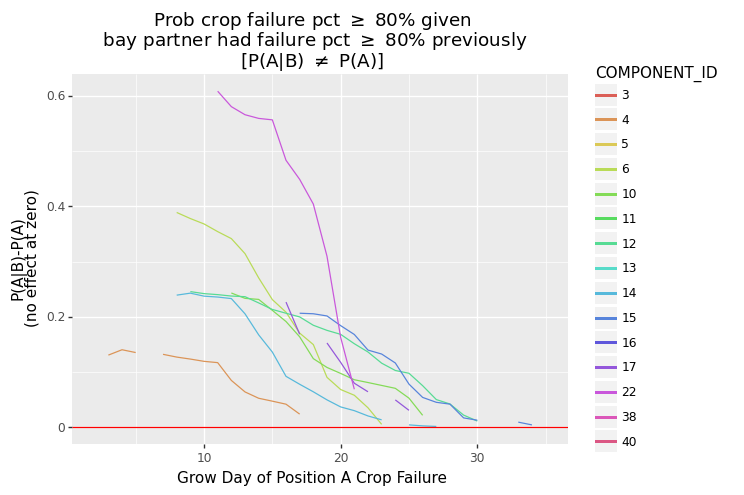

<ggplot: (381070538)>

In [349]:
(
    df_individual
    
    .pipe(lambda d: pd.merge(d, df_conditional, on=['COMPONENT_ID','FIRST_FAILURE_PRED_DAY'],how='outer', suffixes=('','_cond')))
    .query('FIRST_FAILURE_PRED_DAY != -1')

    .filter(items=['COMPONENT_ID', 'FIRST_FAILURE_PRED_DAY','FAILURE_GIVEN_GROW_DAY_A','A_GIVEN_B_FAILED'])

    .assign(diff_prob = lambda d: d['A_GIVEN_B_FAILED']-d['FAILURE_GIVEN_GROW_DAY_A'])    

    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))
    
    .pipe(lambda d: ggplot(d, aes(x='FIRST_FAILURE_PRED_DAY',y='diff_prob', color='COMPONENT_ID')) 
          + geom_line()
          + geom_hline(yintercept=0,color='red')
          + ggtitle("Prob crop failure pct $\geq$ 80% given\n bay partner had failure pct $\geq$ 80% previously\n[P(A|B) $\\neq$ P(A)]")
          + labs(y='P(A|B)-P(A)\n(no effect at zero)',x="Grow Day of Position A Crop Failure"))
)

This shows us that, for A = "crop in position A fails" and B = "crop in position B has failed before crop A" that A|B is different than A, or rather that having another crop fail first is correlated with a measurable effect.

### If we take action on crops when their partner falters, how much time do we gain?

Anticipating these failures, we may wish to preemptively terminate a surviving bay partner and recoup the space. How often does this occur?

In [353]:
qry = f"""
{BAY_PAIRS_SUBQUERY}
    select *,
    
      -- all the mass we saw the bay yielding
      salable_mass_lbs_a + salable_mass_lbs_b as bay_mass,
      
      -- time we could get back by terminating when the first bay fails
      case
           when (first_failure_pred_day_a > first_failure_pred_day_b) and first_failure_pred_day_b <> -1 then first_failure_pred_day_a - first_failure_pred_day_b      
           when (first_failure_pred_day_b > first_failure_pred_day_a) and first_failure_pred_day_a <> -1 then first_failure_pred_day_b - first_failure_pred_day_a
           
           when (first_failure_pred_day_b > first_failure_pred_day_a) and first_failure_pred_day_a = -1 then recipe_days - first_failure_pred_day_b
           when (first_failure_pred_day_a > first_failure_pred_day_b) and first_failure_pred_day_b = -1 then recipe_days - first_failure_pred_day_a
           else 0
           
      end as days_recoupable,
        
      case when (first_failure_pred_day_a > 0 or first_failure_pred_day_b > 0) then 1 else 0 end as predict_any_failure
    
    
    from bay_pairs
"""
df = pd.read_sql(qry,conn)

df.head()

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,CROP_A,OUTCOME_A,SALABLE_MASS_LBS_A,FIRST_FAILURE_PRED_DAY_A,RECIPE_ID_A,TERMINATION_GROW_DAY_A,CROP_B,OUTCOME_B,SALABLE_MASS_LBS_B,FIRST_FAILURE_PRED_DAY_B,RECIPE_ID_B,TERMINATION_GROW_DAY_B,COMPONENT_ID,SEEDED_ON,COMPLETED_ON_SCHEDULED,RECIPE_DAYS,BAY_MASS,DAYS_RECOUPABLE,PREDICT_ANY_FAILURE
0,163362,complete,7.398,-1,443,-1,163375,complete,10.427,-1,443,-1,4,2021-11-21,2021-12-07,16,17.825,0,0
1,125601,complete,53.149,-1,445,-1,125602,complete,35.069,-1,445,-1,12,2021-06-29,2021-07-29,30,88.218,0,0
2,157676,complete,8.534,-1,443,-1,157675,complete,8.503,-1,443,-1,4,2021-10-29,2021-11-14,16,17.037,0,0
3,246433,complete,35.135,-1,641,-1,246405,complete,39.087,-1,641,-1,14,2022-08-16,2022-09-08,23,74.222,0,0
4,78424,complete,26.172,-1,391,-1,78484,complete,15.497,-1,391,-1,14,2020-12-11,2021-01-06,26,41.669,0,0


In [354]:
df.shape

(63538, 19)

In [352]:
df.query('CROP_B==182555')

,CROP_A,OUTCOME_A,SALABLE_MASS_LBS_A,FIRST_FAILURE_PRED_DAY_A,RECIPE_ID_A,TERMINATION_GROW_DAY_A,CROP_B,OUTCOME_B,SALABLE_MASS_LBS_B,FIRST_FAILURE_PRED_DAY_B,RECIPE_ID_B,TERMINATION_GROW_DAY_B,COMPONENT_ID,SEEDED_ON,COMPLETED_ON_SCHEDULED,RECIPE_DAYS,BAY_MASS,DAYS_RECOUPABLE,PREDICT_ANY_FAILURE
4359,182564,complete,31.188,19,608,-1,182555,complete,21.761,19,608,-1,12,2022-02-10,2022-03-11,29,52.949,0,1


Let's look at the performance of Farm 2's crops in the context of crops that we predict will fail.

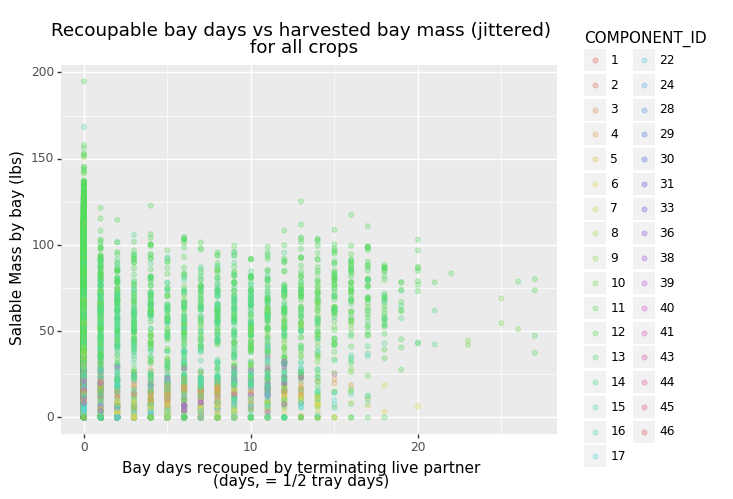

<ggplot: (388608687)>

In [360]:
(
    df    
    
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))

    .pipe(lambda d: ggplot(d, aes(x='DAYS_RECOUPABLE',y='BAY_MASS',color='COMPONENT_ID')) 
#           + geom_jitter(width=0.2,height=0.3)
          + geom_point(alpha=0.3)
          + labs(y="Salable Mass by bay (lbs)",x='Bay days recouped by terminating live partner\n(days, = 1/2 tray days)')
          + ggtitle("Recoupable bay days vs harvested bay mass (jittered)\n for all crops")
         )
)

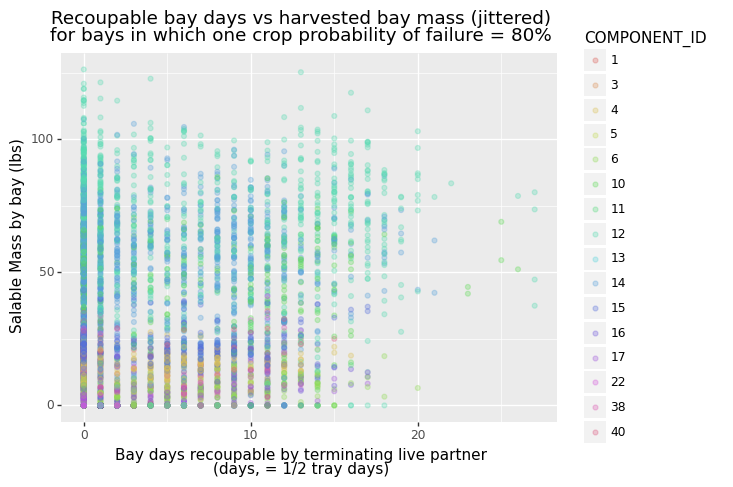

<ggplot: (385599296)>

In [358]:
(
    df
    .query("PREDICT_ANY_FAILURE > 0")
    
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))

    .pipe(lambda d: ggplot(d, aes(x='DAYS_RECOUPABLE',y='BAY_MASS',color='COMPONENT_ID')) 
#           + geom_jitter(width=0.2,height=0.3)
          + geom_point(alpha=0.3)
          + labs(y="Salable Mass by bay (lbs)",x='Bay days recoupable by terminating live partner\n(days, = 1/2 tray days)')
          + ggtitle("Recoupable bay days vs harvested bay mass (jittered)\nfor bays in which one crop probability of failure = 80%")
         )
)

Separating out bays with no recoupable days, and also those with no salable mass:

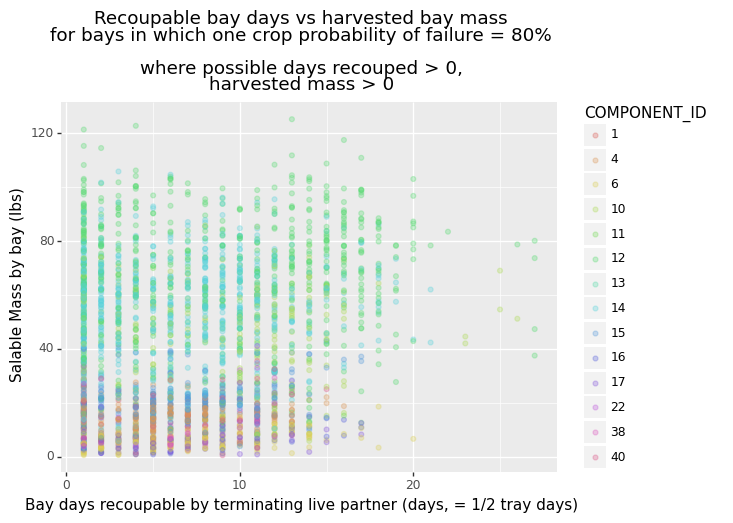

<ggplot: (388868154)>

In [361]:
(
    df
    
    .query("PREDICT_ANY_FAILURE > 0")
    .query('DAYS_RECOUPABLE > 0')
    .query('BAY_MASS > 0')
    
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))
    
    .pipe(lambda d: ggplot(d, aes(x='DAYS_RECOUPABLE',y='BAY_MASS', color='COMPONENT_ID')) 
          + geom_point(alpha=0.3)
          + labs(y="Salable Mass by bay (lbs)",x='Bay days recoupable by terminating live partner (days, = 1/2 tray days)')
          + ggtitle("Recoupable bay days vs harvested bay mass\nfor bays in which one crop probability of failure = 80%\n\nwhere possible days recouped > 0,\nharvested mass > 0"))
)

### What percentage of all bays are represented by these recoupable bays with salable mass?

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 19 rows containing missing values.


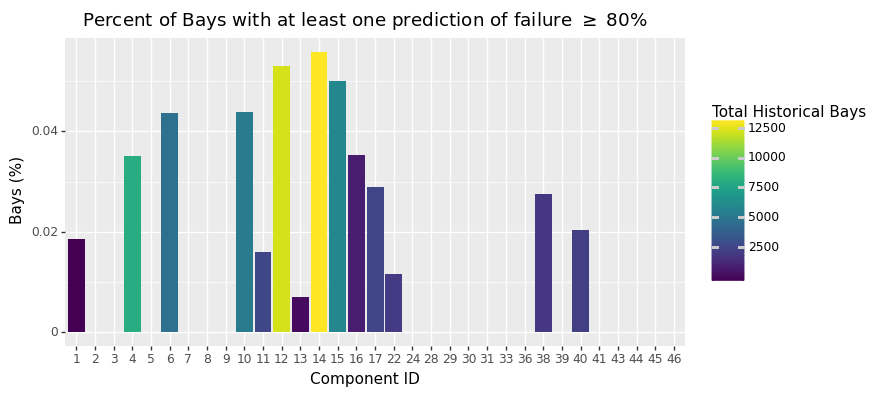

<ggplot: (402523694)>

In [335]:
recoupable = (
    
    df    
    .query('DAYS_RECOUPABLE > 0')
    .query('BAY_MASS > 0')
    .groupby("COMPONENT_ID").size()
)

total = (
    df
    .groupby("COMPONENT_ID").size()
)

(
    pd.DataFrame({'Recoupable':recoupable,'Total':total})
    .assign(percentage = lambda d: d['Recoupable']/d['Total'])
    
    .reset_index()
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))
    .pipe(lambda d: ggplot(d, aes(x='COMPONENT_ID',y='percentage',fill='Total')) 
          + geom_bar(stat='identity')
          + theme(figure_size=(8,4))
          + labs(x='Component ID',y='Bays (%)',fill='Total Historical Bays')
          + ggtitle('Percent of Bays with at least one prediction of failure $\geq$ 80%'))
)


### Should we terminate at the first sign of failure?

In [497]:
qry = f"""
{BAY_PAIRS_SUBQUERY}
    select *,
    
      -- all the mass we saw the bay yielding
      salable_mass_lbs_a + salable_mass_lbs_b as bay_mass,
      
      -- time we could get back by terminating when the first bay fails
      case
           when (first_failure_pred_day_a > first_failure_pred_day_b) and first_failure_pred_day_b <> -1 then first_failure_pred_day_a - first_failure_pred_day_b      
           when (first_failure_pred_day_b > first_failure_pred_day_a) and first_failure_pred_day_a <> -1 then first_failure_pred_day_b - first_failure_pred_day_a
           
           when (first_failure_pred_day_b > first_failure_pred_day_a) and first_failure_pred_day_a = -1 then recipe_days - first_failure_pred_day_b
           when (first_failure_pred_day_a > first_failure_pred_day_b) and first_failure_pred_day_b = -1 then recipe_days - first_failure_pred_day_a
           else 0
           
      end as days_recoupable,
        
      case when (first_failure_pred_day_a > 0 or first_failure_pred_day_b > 0) then 1 else 0 end as predict_any_failure
    
    
    from bay_pairs
"""
df = pd.read_sql(qry,conn)

df.head()

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,CROP_A,OUTCOME_A,SALABLE_MASS_LBS_A,FIRST_FAILURE_PRED_DAY_A,RECIPE_ID_A,TERMINATION_GROW_DAY_A,CROP_B,OUTCOME_B,SALABLE_MASS_LBS_B,FIRST_FAILURE_PRED_DAY_B,RECIPE_ID_B,TERMINATION_GROW_DAY_B,COMPONENT_ID,SEEDED_ON,COMPLETED_ON_SCHEDULED,RECIPE_DAYS,BAY_MASS,DAYS_RECOUPABLE,PREDICT_ANY_FAILURE
0,93361,complete,30.463,-1,447,-1,93365,complete,29.785,-1,417,-1,14,2021-02-19,2021-03-18,27,60.248,0,0
1,96379,complete,5.167,-1,413,-1,96380,complete,4.773,-1,413,-1,17,2021-03-01,2021-03-30,29,9.940,0,0
2,188381,complete,52.723,-1,642,-1,188355,complete,29.978,-1,671,-1,12,2022-03-07,2022-04-06,30,82.701,0,0
3,107964,complete,41.505,-1,447,-1,107967,complete,30.330,-1,447,-1,14,2021-04-23,2021-05-20,27,71.835,0,0
4,268163,complete,47.108,-1,642,-1,268164,complete,40.598,-1,642,-1,12,2022-10-05,2022-11-04,30,87.706,0,0


In [498]:
df.query("PREDICT_ANY_FAILURE > 0").head()

,CROP_A,OUTCOME_A,SALABLE_MASS_LBS_A,FIRST_FAILURE_PRED_DAY_A,RECIPE_ID_A,TERMINATION_GROW_DAY_A,CROP_B,OUTCOME_B,SALABLE_MASS_LBS_B,FIRST_FAILURE_PRED_DAY_B,RECIPE_ID_B,TERMINATION_GROW_DAY_B,COMPONENT_ID,SEEDED_ON,COMPLETED_ON_SCHEDULED,RECIPE_DAYS,BAY_MASS,DAYS_RECOUPABLE,PREDICT_ANY_FAILURE
5,200271,complete,28.741,8,449,-1,200272,complete,23.184,8,449,-1,10,2022-04-25,2022-05-20,25,51.925,0,1
6,191134,complete,11.971,22,654,-1,191135,complete,8.800,22,654,-1,15,2022-03-16,2022-04-14,29,20.771,0,1
14,200261,terminated,0.000,2,642,30,200259,complete,42.498,2,642,-1,12,2022-04-25,2022-05-25,30,42.498,0,1
15,195691,complete,8.946,16,489,-1,195690,complete,8.143,-1,489,-1,4,2022-04-10,2022-04-27,17,17.089,1,1
30,196839,complete,25.326,11,621,-1,196838,complete,27.244,11,621,-1,14,2022-04-15,2022-05-12,27,52.570,0,1


In [499]:
df.shape

(63549, 19)

### Rolling bay mass quantiles

Per component, let's determine where a bay mass ranked over the last 30 days

In [532]:
def summarize(window_start, window_end, df):
    
    df_subset = (
        df
        .assign(COS = lambda d: pd.to_datetime(d['COMPLETED_ON_SCHEDULED']))
        .query(f"COS >= '{window_start}'")
        .query(f"COS <= '{window_end}'")
    )
    rows_of_interest_this_window = df_subset.query(f"COS == '{window_end}'")
    
    # I only want the distribution of bays which have experienced NO PREDICTED FAILURES, 
    # that is, compare all bays against what's normal for healthy bays
    healthy_bay_distribution = (
        df_subset
        .query("OUTCOME_A=='complete'")
        .query("OUTCOME_B=='complete'")
        .query("PREDICT_ANY_FAILURE == 0")
        ['BAY_MASS'].agg({'size','mean','std'})
    )
        
    # where do our failure-detected bays fall?
    
    rows_of_interest_augmented = rows_of_interest_this_window.assign(pctle = lambda d: norm.cdf(x=d['BAY_MASS'], loc=healthy_bay_distribution['mean'], scale=healthy_bay_distribution['std']))
    
    return rows_of_interest_augmented, healthy_bay_distribution

In [533]:
df_list = {}
dist_list = {}

for component_id in df['COMPONENT_ID'].unique():
    
    df_component = df.query(f"COMPONENT_ID == {component_id}")
    
    if len(df_component) > 100:
        dates_between = [df_component['COMPLETED_ON_SCHEDULED'].min() + datetime.timedelta(days=x) for x in range((df_component['COMPLETED_ON_SCHEDULED'].max() - df_component['COMPLETED_ON_SCHEDULED'].min()).days)]
        
        for end_date in dates_between:
        
            start_date = end_date - datetime.timedelta(days=30)
        
            df_list[(component_id,end_date)], dist_list[(component_id,end_date)] = summarize(start_date, end_date, df_component)

In [534]:
df_results = pd.concat(df_list)

In [535]:
df.shape

(63549, 19)

In [536]:
df_results.shape

(63210, 21)

In [537]:
df_results.head()

CROP_A   OUTCOME_A  SALABLE_MASS_LBS_A  \
14 2020-04-16 62218   33117  terminated               0.000   
   2020-04-20 33872   31859    complete              20.886   
   2020-04-21 21151   31943    complete              19.691   
   2020-04-26 15812   32570    complete              20.286   
              39722   32575    complete              25.644   

                     FIRST_FAILURE_PRED_DAY_A  RECIPE_ID_A  \
14 2020-04-16 62218                        -1          370   
   2020-04-20 33872                        -1          370   
   2020-04-21 21151                        -1          370   
   2020-04-26 15812                        -1          370   
              39722                        -1          370   

                     TERMINATION_GROW_DAY_A  CROP_B   OUTCOME_B  \
14 2020-04-16 62218                      -1   33114  terminated   
   2020-04-20 33872                      -1   31858    complete   
   2020-04-21 21151                      -1   31941    complete   
   2020-04-26 15812                      -1   32568    complete   
              39722                      -1   32574    complete   

                     SALABLE_MASS_LBS_B  FIRST_FAILURE_PRED_DAY_B  ...  \
14 2020-04-16 62218               0.000                        -1  ...   
   2020-04-20 33872              10.520                        -1  ...   
   2020-04-21 21151              18.210                        -1  ...   
   2020-04-26 15812              11.336                        -1  ...   
              39722              16.424                        -1  ...   

                     TERMINATION_GROW_DAY_B  COMPONENT_ID   SEEDED_ON  \
14 2020-04-16 62218                      -1            14  2020-04-04   
   2020-04-20 33872                      -1            14  2020-03-25   
   2020-04-21 21151                      -1            14  2020-03-26   
   2020-04-26 15812                      -1            14  2020-03-31   
              39722                      -1            14  2020-03-31   

                    COMPLETED_ON_SCHEDULED RECIPE_DAYS  BAY_MASS  \
14 2020-04-16 62218             2020-04-16          12     0.000   
   2020-04-20 33872             2020-04-20          26    31.406   
   2020-04-21 21151             2020-04-21          26    37.901   
   2020-04-26 15812             2020-04-26          26    31.622   
              39722             2020-04-26          26    42.068   

                     DAYS_RECOUPABLE  PREDICT_ANY_FAILURE        COS     pctle  
14 2020-04-16 62218                0                    0 2020-04-16       NaN  
   2020-04-20 33872                0                    0 2020-04-20       NaN  
   2020-04-21 21151                0                    0 2020-04-21  0.760250  
   2020-04-26 15812                0                    0 2020-04-26  0.153116  
              39722                0                    0 2020-04-26  0.859527  

[5 rows x 21 columns]

In [548]:
df_results.groupby(['COMPONENT_ID','PREDICT_ANY_FAILURE']).size().reset_index().set_index(['COMPONENT_ID','PREDICT_ANY_FAILURE'])

0
COMPONENT_ID PREDICT_ANY_FAILURE       
3            0                      218
             1                       14
4            0                     7322
             1                      642
5            0                      602
             1                        1
6            0                     4235
             1                      509
9            0                      252
10           0                     4882
             1                      444
11           0                     2655
             1                       99
12           0                    10831
             1                     1053
13           0                      427
             1                        4
14           0                    11424
             1                     1307
15           0                     5102
             1                      806
16           0                      900
             1                      117
17           0                     2411
             1                      221
22           0                     1808
             1                      440
38           0                     1953
             1                      120
40           0                     2324
             1                       87

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 359 rows containing non-finite values.


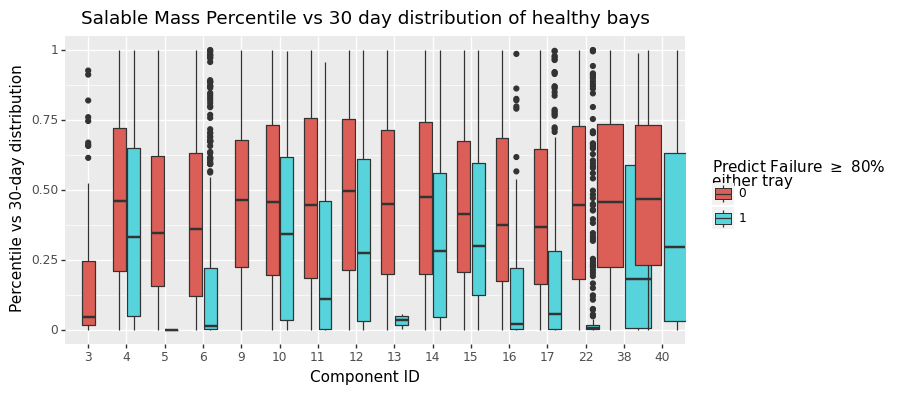

<ggplot: (362596310)>

In [542]:
(
    df_results
    
    .assign(PREDICT_ANY_FAILURE = lambda d: pd.Categorical(d['PREDICT_ANY_FAILURE']))
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))
    .pipe(lambda d: ggplot(d, aes(x='COMPONENT_ID',y='pctle',fill='PREDICT_ANY_FAILURE')) 
          + geom_boxplot() 
          + theme(figure_size=(8,4))
          + labs(x='Component ID',y='Percentile vs 30-day distribution',fill="Predict Failure $\geq$ 80%\neither tray")
          + ggtitle("Salable Mass Percentile vs 30 day distribution of healthy bays"))
)

/Users/pmccarthy/git/overseed-and-cull/venv/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 69 rows containing non-finite values.


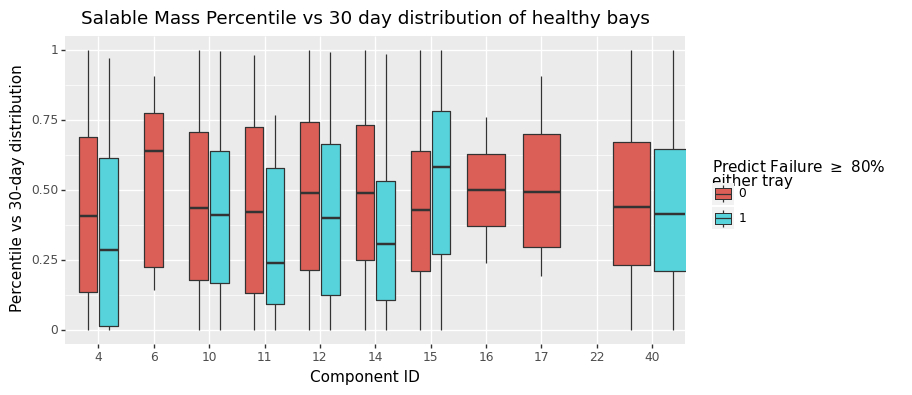

<ggplot: (439312038)>

In [552]:
(
    df_results
        .query("COMPLETED_ON_SCHEDULED < datetime.date(2022,7,19)")
        .query("COMPLETED_ON_SCHEDULED >= datetime.date(2022,5,1)")
    .assign(PREDICT_ANY_FAILURE = lambda d: pd.Categorical(d['PREDICT_ANY_FAILURE']))
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))
    .pipe(lambda d: ggplot(d, aes(x='COMPONENT_ID',y='pctle',fill='PREDICT_ANY_FAILURE')) 
          + geom_boxplot() 
          + theme(figure_size=(8,4))
          + labs(x='Component ID',y='Percentile vs 30-day distribution',fill="Predict Failure $\geq$ 80%\neither tray")
          + ggtitle("Salable Mass Percentile vs 30 day distribution of healthy bays"))
)

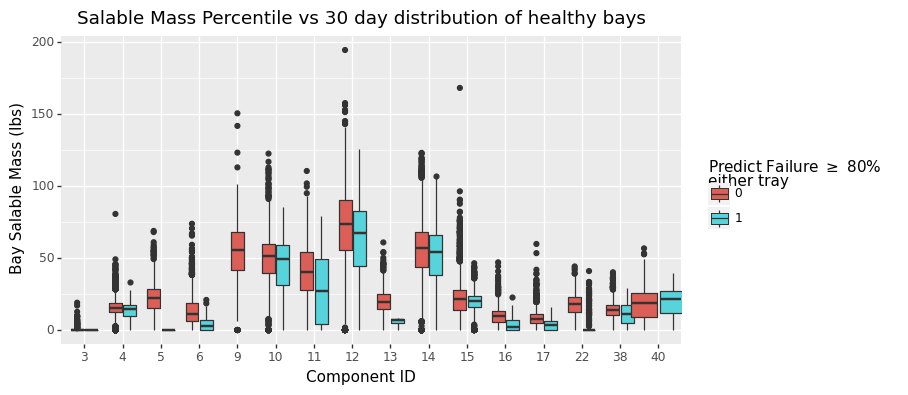

<ggplot: (437746532)>

In [549]:
(
    df_results
    
    .assign(PREDICT_ANY_FAILURE = lambda d: pd.Categorical(d['PREDICT_ANY_FAILURE']))
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))
    .pipe(lambda d: ggplot(d, aes(x='COMPONENT_ID',y='BAY_MASS',fill='PREDICT_ANY_FAILURE')) 
          
          + geom_boxplot()           
          + theme(figure_size=(8,4))
          + labs(x='Component ID',y='Bay Salable Mass (lbs)',fill="Predict Failure $\geq$ 80%\neither tray")
          + ggtitle("Salable Mass Percentile vs 30 day distribution of healthy bays"))
)

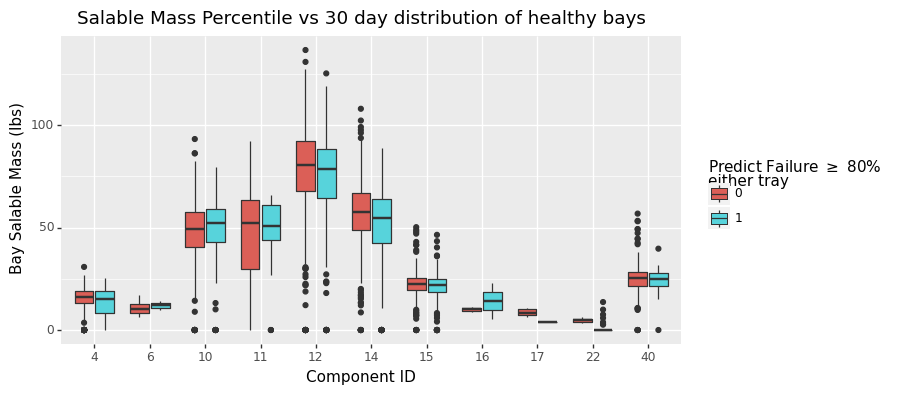

<ggplot: (437615797)>

In [551]:
(
    df_results
    .query("COMPLETED_ON_SCHEDULED < datetime.date(2022,7,19)")
        .query("COMPLETED_ON_SCHEDULED >= datetime.date(2022,5,1)")

    
    .assign(PREDICT_ANY_FAILURE = lambda d: pd.Categorical(d['PREDICT_ANY_FAILURE']))
    .assign(COMPONENT_ID = lambda d: pd.Categorical(d['COMPONENT_ID']))
    .pipe(lambda d: ggplot(d, aes(x='COMPONENT_ID',y='BAY_MASS',fill='PREDICT_ANY_FAILURE')) 
          
          + geom_boxplot()           
          + theme(figure_size=(8,4))
          + labs(x='Component ID',y='Bay Salable Mass (lbs)',fill="Predict Failure $\geq$ 80%\neither tray")
          + ggtitle("Salable Mass Percentile vs 30 day distribution of healthy bays"))
)